# Attention probing (with pronoun-variant control)
This notebook integrates an I→they pronoun-variant manipulation into the probe pipeline.

**Design:** 20 templates × 3 valences (neg/neu/pos) × 2 pronoun variants (I/they) × 2 models (pretrained/finetuned) × 2 layer aggregations (last4/all).

In [203]:
# Import necessary packages (each imported once)
import re
import numpy as np
import pandas as pd
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import HTML, display
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Set device for computation (GPU if available, otherwise CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)


DEVICE: cpu


## 1) Build probes (20 sets × 3 valences)

In [204]:
triplets = [
    # set_id, pos, neu(flat), neg, template (same structure as your original)
    (1,  "happy",      "normal",    "awful",       "When I think about the future, I feel {w}."),
    (2,  "energized",  "regular",   "burned out",  "Right now, I feel {w}."),
    (3,  "calm",       "typical",   "horrible",    "{W} is what I feel after I finally sit down."),
    (4,  "connected",  "normal",    "isolated",   "{W} is what I feel after talking to people online."),
    (5,  "proud",      "ordinary",  "embarrassed","I feel {w} when I actually finish something."),
    (6,  "safe",       "routine",   "uneasy",     "Most days, I feel {w} at home."),
    (7,  "motivated",  "typical",   "daunted",    "{W} is what I feel when I start a task."),
    (8,  "interested", "standard",  "detached",   "I feel {w} when something new pops up."),
    (9,  "rested",     "normal",    "drained",    "After I wake up, I feel {w}."),
    (10, "confident",  "usual",     "lost",       "{W} is what I feel about my plans."),

    # new 10 sets (11–20)
    (11, "relieved",   "normal",    "stressed",   "I feel {w} after I get some space."),
    (12, "grateful",   "regular",   "hollow",     "{W} is what I feel when someone checks in."),
    (13, "excited",    "typical",   "worried",    "Right now, I feel {w} about what’s coming."),
    (14, "content",    "ordinary",  "trapped",    "I feel {w} when the day finally slows down."),
    (15, "optimistic", "usual",     "discouraged","{W} is what I feel after thinking it through."),
    (16, "supported",  "standard",  "ignored","{W} is what I feel after talking it out."),
    (17, "refreshed",  "normal",    "miserable",  "I feel {w} after I take a short break."),
    (18, "inspired",   "regular",   "frustrated", "I feel {w} when I see someone do well."),
    (19, "cheerful",   "typical",   "defeated",   "Most days, I feel {w} in the morning."),
    (20, "peaceful",   "usual",     "restless",   "{W} is what I feel when everything goes quiet."),
]


rows = []
sentence_id = 0

for set_id, pos, neu, neg, tmpl in triplets:
   for valence, word in [("pos", pos), ("neu", neu), ("neg", neg)]:
                sentence_id += 1
                sentence = tmpl.format(w=word, W=word.capitalize())
                rows.append({
                    "sentence_id": sentence_id,
                    "set_id": set_id,
                    "valence": valence,
                    "emotion_word": word,
                    "pronoun_word": "I",
                    "sentence": sentence,
                })

stimuli_df = pd.DataFrame(rows)
display(stimuli_df.head(12))
print("n_sentences:", len(stimuli_df), "| n_sets:", stimuli_df["set_id"].nunique())


,sentence_id,set_id,valence,emotion_word,pronoun_word,sentence
0,1,1,pos,happy,I,"When I think about the future, I feel happy."
1,2,1,neu,normal,I,"When I think about the future, I feel normal."
2,3,1,neg,awful,I,"When I think about the future, I feel awful."
3,4,2,pos,energized,I,"Right now, I feel energized."
4,5,2,neu,regular,I,"Right now, I feel regular."
5,6,2,neg,burned out,I,"Right now, I feel burned out."
6,7,3,pos,calm,I,Calm is what I feel after I finally sit down.
7,8,3,neu,typical,I,Typical is what I feel after I finally sit down.
8,9,3,neg,horrible,I,Horrible is what I feel after I finally sit down.
9,10,4,pos,connected,I,Connected is what I feel after talking to peop...


n_sentences: 60 | n_sets: 20


## 2) Create pronoun-variant control (I vs they)
We duplicate each probe sentence and replace **standalone** `I` tokens with `they` (capitalized as `They` if sentence-initial). The analysis then treats `pronoun_variant` as a factor.

In [205]:
def make_pronoun_variant_df(stimuli_df: pd.DataFrame,
                            src_pronoun: str = "I",
                            tgt_pronoun: str = "they") -> pd.DataFrame:
    pattern = re.compile(rf"\b{re.escape(src_pronoun)}\b")

    def replace(text: str) -> str:
        def repl(m: re.Match) -> str:
            return tgt_pronoun.capitalize() if m.start() == 0 else tgt_pronoun
        return pattern.sub(repl, text)

    df_src = stimuli_df.copy()
    df_src["pronoun_variant"] = src_pronoun
    df_src["pronoun_word"] = src_pronoun

    df_tgt = stimuli_df.copy()
    df_tgt["sentence"] = df_tgt["sentence"].apply(replace)
    df_tgt["pronoun_variant"] = tgt_pronoun
    df_tgt["pronoun_word"] = tgt_pronoun

    out = pd.concat([df_src, df_tgt], ignore_index=True)
    out["sentence_id"] = range(1, len(out) + 1)
    return out

stimuli_df_var = make_pronoun_variant_df(stimuli_df, src_pronoun="I", tgt_pronoun="they")
display(stimuli_df_var.sample(8, random_state=0)[["set_id","valence","pronoun_variant","pronoun_word","sentence"]])
print("rows:", len(stimuli_df_var), "| variants:", stimuli_df_var["pronoun_variant"].value_counts().to_dict())


,set_id,valence,pronoun_variant,pronoun_word,sentence
48,17,pos,I,I,I feel refreshed after I take a short break.
94,12,neu,they,they,Regular is what they feel when someone checks in.
95,12,neg,they,they,Hollow is what they feel when someone checks in.
8,3,neg,I,I,Horrible is what I feel after I finally sit down.
97,13,neu,they,they,"Right now, they feel typical about what’s coming."
22,8,neu,I,I,I feel standard when something new pops up.
7,3,neu,I,I,Typical is what I feel after I finally sit down.
10,4,neu,I,I,Normal is what I feel after talking to people ...


rows: 120 | variants: {'I': 60, 'they': 60}


## 3) Save probes

In [206]:
out_dir = Path("/Users/nadiahajighassem/Documents/GitHub/NLP_2025/extra")
stimuli_df.to_csv(out_dir / "reddit_probe_triplets_20.csv", index=False)

stimuli_df_var.to_csv(out_dir / "reddit_probe_triplets_20_pronounvar.csv", index=False)

print("Saved probes to:", out_dir.resolve())


Saved probes to: /Users/nadiahajighassem/Documents/GitHub/NLP_2025/extra


### Load model B

In [207]:
FINETUNED_PATH = "./runs/bert_tuned_lr3e-5_ep3/best_model" 
PRETRAINED_ID = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_ID, use_fast=True)

pretrained = AutoModelForSequenceClassification.from_pretrained(
    PRETRAINED_ID, num_labels=2
).to(DEVICE).eval()

finetuned = AutoModelForSequenceClassification.from_pretrained(
    FINETUNED_PATH
).to(DEVICE).eval()

print("Loaded pretrained + finetuned.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded pretrained + finetuned.


## 5) Attention helpers + probe runner


This code help calculate and compare the effects of emotion words and pronoun attention using Difference-in-Differences (DID) and Difference (DDD) methods. It applies non-parametric inference (bootstrapping and permutation tests) to generate statistical summaries, and outputs report-ready tables for emotion word attention across different layers, including Holm-Bonferroni correction for pronoun attention.

In [208]:
def find_all_word_spans(text: str, word: str, *, case_insensitive: bool = True):
    flags = re.IGNORECASE if case_insensitive else 0
    pattern = re.compile(rf"\b{re.escape(word)}\b", flags=flags)
    return [(m.start(), m.end()) for m in pattern.finditer(text)]

def token_indices_for_char_span(enc, span):
    start, end = span
    offsets = enc["offset_mapping"][0].tolist()
    idxs = []
    for i, (s, e) in enumerate(offsets):
        if s == 0 and e == 0:
            continue
        if max(s, start) < min(e, end):
            idxs.append(i)
    return idxs

def non_special_token_indices(enc):
    offsets = enc["offset_mapping"][0].tolist()
    return [i for i,(s,e) in enumerate(offsets) if not (s==0 and e==0)]

def get_attn_matrix(model, enc, device, *, layer_agg="last4"):
    model_inputs = {k: v.to(device) for k, v in enc.items() if k != "offset_mapping"}
    out = model(**model_inputs, output_attentions=True, return_dict=True)
    attns = out.attentions
    if layer_agg == "last4":
        layers = attns[-4:]
    elif layer_agg == "all":
        layers = attns
    else:
        raise ValueError("layer_agg must be 'last4' or 'all'")
    A = torch.stack(layers, dim=0).mean(dim=2).mean(dim=0)[0].detach().cpu().numpy()
    return A

def attn_between_sets(A, src_idxs, tgt_idxs):
    if len(src_idxs) == 0 or len(tgt_idxs) == 0:
        return np.nan
    return float(np.mean(A[np.ix_(src_idxs, tgt_idxs)]))

def incoming_to_set(A, src_valid, tgt_idxs, *, exclude_self=True):
    if len(tgt_idxs) == 0:
        return np.nan
    src = list(src_valid)
    if exclude_self:
        src = [i for i in src if i not in tgt_idxs]
    if len(src) == 0:
        return np.nan
    return float(np.mean(A[np.ix_(src, tgt_idxs)]))

# baseline 
def incoming_baseline(A, valid_idxs, *, exclude_idxs):
    valid_idxs = list(valid_idxs)
    A_sub = A[np.ix_(valid_idxs, valid_idxs)].copy()
    np.fill_diagonal(A_sub, 0.0)
    incoming_per_token = A_sub.mean(axis=0)
    exclude = set(exclude_idxs)
    noncue_pos = [k for k, tok_i in enumerate(valid_idxs) if tok_i not in exclude]
    if len(noncue_pos) == 0:
        return np.nan
    return float(np.mean(incoming_per_token[noncue_pos]))

@torch.no_grad()
def probe_sentence(text, pronoun_word, emotion_word, model, tokenizer, device, *, layer_agg="last4"):
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=False,
        return_offsets_mapping=True,
    )

    pron_spans = find_all_word_spans(text, pronoun_word)
    emo_spans  = find_all_word_spans(text, emotion_word)

    if len(pron_spans) == 0:
        raise ValueError(f"No pronoun '{pronoun_word}' in: {text!r}")
    if len(emo_spans) != 1:
        raise ValueError(f"Expected exactly 1 emotion '{emotion_word}' in: {text!r} (found {len(emo_spans)})")

    pron_idxs = sorted(set(sum([token_indices_for_char_span(enc, s) for s in pron_spans], [])))
    emo_idxs  = sorted(set(token_indices_for_char_span(enc, emo_spans[0])))

    A = get_attn_matrix(model, enc, device, layer_agg=layer_agg)
    valid = non_special_token_indices(enc)

    p_to_e = attn_between_sets(A, pron_idxs, emo_idxs)
    e_to_p = attn_between_sets(A, emo_idxs, pron_idxs)

    all_to_e = incoming_to_set(A, valid, emo_idxs, exclude_self=True)
    all_to_p = incoming_to_set(A, valid, pron_idxs, exclude_self=True)

    exclude = set(pron_idxs + emo_idxs)
    base_incoming = incoming_baseline(A, valid, exclude_idxs=exclude)

    return {
        "p_to_e": p_to_e,
        "e_to_p": e_to_p,
        "all_to_e": all_to_e,
        "all_to_p": all_to_p,
        "all_to_e_norm": (all_to_e - base_incoming) if np.isfinite(all_to_e) and np.isfinite(base_incoming) else np.nan,
        "all_to_p_norm": (all_to_p - base_incoming) if np.isfinite(all_to_p) and np.isfinite(base_incoming) else np.nan,
    }

def run_probes(df, model, model_name, *, layer_agg="last4"):
    out = []
    for r in df.to_dict("records"):
        attn = probe_sentence(
            text=r["sentence"],
            pronoun_word=r["pronoun_word"],
            emotion_word=r["emotion_word"],
            model=model,
            tokenizer=tokenizer,
            device=DEVICE,
            layer_agg=layer_agg,
        )
        out.append({**r, **attn, "model": model_name, "layer_agg": layer_agg})
    return pd.DataFrame(out)


## 6) Attention for probes

In [209]:
res = []
for layer_agg in ["last4", "all"]:
    res.append(run_probes(stimuli_df_var, pretrained, "pretrained", layer_agg=layer_agg))
    res.append(run_probes(stimuli_df_var, finetuned,  "finetuned",  layer_agg=layer_agg))

results = pd.concat(res, ignore_index=True)
display(results.head(8))
print("results shape:", results.shape)
print(results["model"].value_counts().to_dict())
print(results["pronoun_variant"].value_counts().to_dict())

results.to_csv("/Users/nadiahajighassem/Documents/GitHub/NLP_2025/extra/probe_attention_results_pronounvar.csv", index=False)
print("Saved: probe_attention_results_pronounvar.csv")


,sentence_id,set_id,valence,emotion_word,pronoun_word,sentence,pronoun_variant,p_to_e,e_to_p,all_to_e,all_to_p,all_to_e_norm,all_to_p_norm,model,layer_agg
0,1,1,pos,happy,I,"When I think about the future, I feel happy.",I,0.023399,0.015789,0.031112,0.021865,-0.026206,-0.035453,pretrained,last4
1,2,1,neu,normal,I,"When I think about the future, I feel normal.",I,0.028639,0.015802,0.037027,0.022197,-0.019771,-0.034601,pretrained,last4
2,3,1,neg,awful,I,"When I think about the future, I feel awful.",I,0.028305,0.015321,0.034891,0.019168,-0.025273,-0.040996,pretrained,last4
3,4,2,pos,energized,I,"Right now, I feel energized.",I,0.015419,0.022328,0.014341,0.031066,-0.070022,-0.053297,pretrained,last4
4,5,2,neu,regular,I,"Right now, I feel regular.",I,0.051048,0.034801,0.049093,0.042688,-0.025341,-0.031745,pretrained,last4
5,6,2,neg,burned out,I,"Right now, I feel burned out.",I,0.024568,0.026667,0.022519,0.035157,-0.061763,-0.049125,pretrained,last4
6,7,3,pos,calm,I,Calm is what I feel after I finally sit down.,I,0.034766,0.008392,0.049833,0.021270,0.000650,-0.027912,pretrained,last4
7,8,3,neu,typical,I,Typical is what I feel after I finally sit down.,I,0.042462,0.012152,0.046203,0.020577,-0.004967,-0.030593,pretrained,last4


results shape: (480, 15)
{'pretrained': 240, 'finetuned': 240}
{'I': 240, 'they': 240}
Saved: probe_attention_results_pronounvar.csv


## 7) Plots 
Bars are valence; x-axis groups by `(model, pronoun_variant)`.

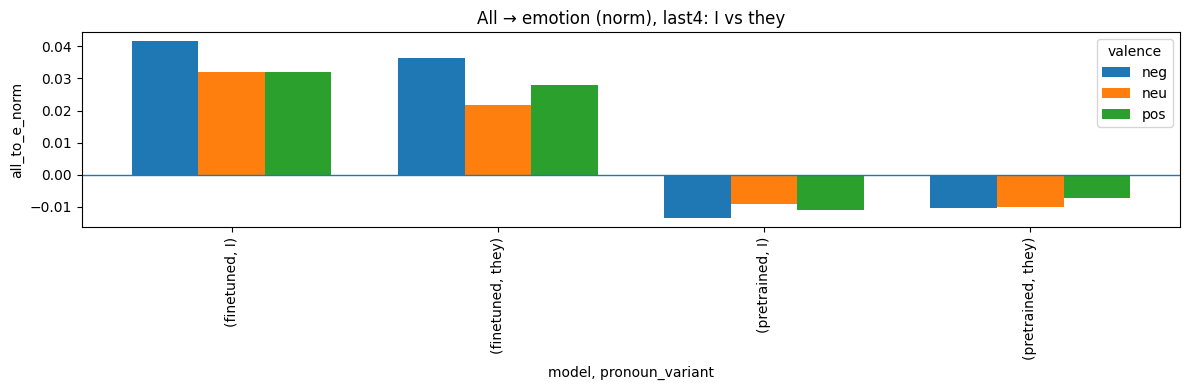

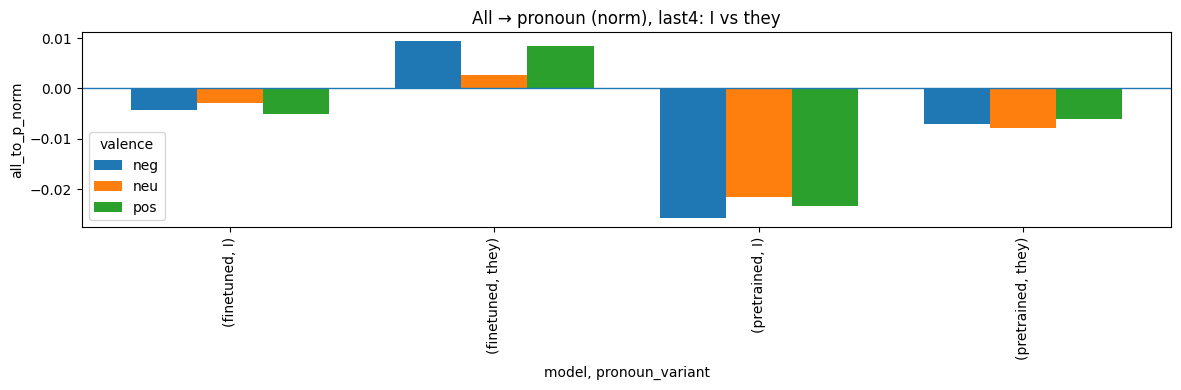

In [210]:

def grouped_bar(results, metric, *, layer_agg="last4", title=None, ylabel=None, savepath=None):
    d = results[results["layer_agg"] == layer_agg].copy()
    agg = (d.groupby(["model","pronoun_variant","valence"], as_index=False)[metric].mean())
    wide = (agg.pivot_table(index=["model","pronoun_variant"], columns="valence", values=metric)
              .reindex(columns=["neg","neu","pos"]))

    x_labels = [f"({m}, {p})" for (m, p) in wide.index]
    x = np.arange(len(wide.index))
    bar_w = 0.25

    fig, ax = plt.subplots(figsize=(12, 4))
    for i, val in enumerate(["neg","neu","pos"]):
        ax.bar(x + (i - 1) * bar_w, wide[val].values, width=bar_w, label=val)

    ax.axhline(0, linewidth=1)
    ax.set_title(title or f"{metric} ({layer_agg})")
    ax.set_ylabel(ylabel or metric)
    ax.set_xlabel("model, pronoun_variant")
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=90)
    ax.legend(title="valence")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=220, bbox_inches="tight")
    plt.show()

grouped_bar(results, "all_to_e_norm", layer_agg="last4",
            title="All → emotion (norm), last4: I vs they",
            ylabel="all_to_e_norm",
            savepath="/Users/nadiahajighassem/Documents/GitHub/NLP_2025/results/figures/Emotion_attention.png")

grouped_bar(results, "all_to_p_norm", layer_agg="last4",
            title="All → pronoun (norm), last4: I vs they",
            ylabel="all_to_p_norm",
            savepath="/Users/nadiahajighassem/Documents/GitHub/NLP_2025/results/figures/Pronoun_attention.png")



## 8) Stats


In [214]:

def did_table(results: pd.DataFrame, metric: str, *, contrast=("neg", "pos"), layer_agg="last4") -> pd.DataFrame:
    a, b = contrast
    d = results.loc[results["layer_agg"] == layer_agg].copy()

    wide = (
        d.pivot_table(
            index=["model", "pronoun_variant", "set_id"],
            columns="valence",
            values=metric,
            aggfunc="mean",
        )
        .reset_index()
    )

    wide = wide.dropna(subset=[a, b]).copy()
    wide["delta"] = wide[a] - wide[b]

    ft = (
        wide.loc[wide["model"] == "finetuned", ["pronoun_variant", "set_id", "delta"]]
        .rename(columns={"delta": "delta_ft"})
    )
    pr = (
        wide.loc[wide["model"] == "pretrained", ["pronoun_variant", "set_id", "delta"]]
        .rename(columns={"delta": "delta_pre"})
    )

    m = ft.merge(pr, on=["pronoun_variant", "set_id"], how="inner")
    m["did"] = m["delta_ft"] - m["delta_pre"]
    return m


def make_ddd(m_did: pd.DataFrame) -> pd.DataFrame:
    mi = m_did.loc[m_did["pronoun_variant"] == "I", ["set_id", "did"]].rename(columns={"did": "did_I"})
    mt = m_did.loc[m_did["pronoun_variant"] == "they", ["set_id", "did"]].rename(columns={"did": "did_they"})
    ddd = mi.merge(mt, on="set_id", how="inner")
    ddd["ddd"] = ddd["did_I"] - ddd["did_they"]
    return ddd



# Nonparam inference helpers
def bootstrap_ci_mean(x, *, n_boot=20000, ci=0.95, rng=None):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return (np.nan, np.nan)
    if rng is None:
        rng = np.random.default_rng(42)
    boots = rng.choice(x, size=(n_boot, x.size), replace=True).mean(axis=1)
    lo = float(np.quantile(boots, (1 - ci) / 2))
    hi = float(np.quantile(boots, 1 - (1 - ci) / 2))
    return lo, hi


def permutation_pvalue_signflip_mean(x, *, n_perm=200000, rng=None, two_sided=True):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.nan
    if rng is None:
        rng = np.random.default_rng(42)

    obs = float(np.mean(x))
    signs = rng.choice([-1, 1], size=(n_perm, x.size))
    perm_means = (signs * x).mean(axis=1)

    if two_sided:
        return float((np.abs(perm_means) >= abs(obs)).mean())
    return float((perm_means >= obs).mean())


def summarize_nonparam(x, *, n_boot=20000, n_perm=200000, seed=42):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]

    rng_boot = np.random.default_rng(seed)
    rng_perm = np.random.default_rng(seed + 1)

    ci_lo, ci_hi = bootstrap_ci_mean(x, n_boot=n_boot, rng=rng_boot)
    return {
        "mean": float(np.mean(x)) if x.size else np.nan,
        "ci_lo": ci_lo,
        "ci_hi": ci_hi,
        "perm_p": permutation_pvalue_signflip_mean(x, n_perm=n_perm, rng=rng_perm),
    }



# Holm correction (pronoun table only)
def holm_bonferroni(pvals):
    pvals = np.asarray(pvals, dtype=float)
    m = len(pvals)
    order = np.argsort(pvals)
    adj = np.empty(m, dtype=float)
    running_max = 0.0
    for k, idx in enumerate(order):
        adj_p = (m - k) * pvals[idx]
        running_max = max(running_max, adj_p)
        adj[idx] = min(running_max, 1.0)
    return adj



# 3 rows: DID(I), DID(they), DDD)
def build_block_table(
    results: pd.DataFrame,
    *,
    outcome: str,
    metric: str,
    layer_agg: str,
    contrast=("neg", "pos"),
    n_boot=20000,
    n_perm=200000,
    seed=42,
    decimals=5,
) -> pd.DataFrame:
    m = did_table(results, metric, contrast=contrast, layer_agg=layer_agg)
    contrast_str = f"{contrast[0]}-{contrast[1]}"
    rows = []
    seed_counter = 0

    for pv in ["I", "they"]:
        x = m.loc[m["pronoun_variant"] == pv, "did"].to_numpy()
        s = summarize_nonparam(x, n_boot=n_boot, n_perm=n_perm, seed=seed + seed_counter)
        seed_counter += 11
        rows.append({
            "Outcome": outcome,
            "Layers": layer_agg,
            "Contrast": contrast_str,
            "Test": "DID",
            "Variant": pv,
            **s
        })

    ddd = make_ddd(m)
    x = ddd["ddd"].to_numpy()
    s = summarize_nonparam(x, n_boot=n_boot, n_perm=n_perm, seed=seed + seed_counter)
    rows.append({
        "Outcome": outcome,
        "Layers": layer_agg,
        "Contrast": contrast_str,
        "Test": "DDD (I - they)",
        "Variant": "I_vs_they",
        **s
    })

    df = pd.DataFrame(rows)

    df["Effect (mean [95% CI])"] = df.apply(
        lambda r: "" if not np.isfinite(r["mean"])
        else f"{r['mean']:.{decimals}f} [{r['ci_lo']:.{decimals}f}, {r['ci_hi']:.{decimals}f}]",
        axis=1
    )

    
    df = df[[
        "Outcome", "Layers", "Contrast", "Test", "Variant",
        "Effect (mean [95% CI])", "perm_p"
    ]].rename(columns={
        "perm_p": "Permutation p"
    })

    return df


# 1) Emotion words (LAST-4 layers)
emotion_last4_table = build_block_table(
    results,
    outcome="Emotion token",
    metric="all_to_e_norm",
    layer_agg="last4",
    contrast=("neg", "pos"),
)

display(emotion_last4_table)
emotion_last4_table.to_csv("/Users/nadiahajighassem/Documents/GitHub/NLP_2025/results/table_emotion_last4.csv", index=False)



# 2) Pronoun attention (LAST-4 layers) + Holm correction across 3 rows
pronoun_last4_table = build_block_table(
    results,
    outcome="Pronoun token(s)",
    metric="all_to_p_norm",
    layer_agg="last4",
    contrast=("neg", "pos"),
)

pronoun_last4_table = pronoun_last4_table.copy()
pronoun_last4_table["Holm"] = holm_bonferroni(pronoun_last4_table["Permutation p"].to_numpy())

display(pronoun_last4_table)
pronoun_last4_table.to_csv("/Users/nadiahajighassem/Documents/GitHub/NLP_2025/results/table_pronoun_last4_holm.csv", index=False)


# 3) Emotion words (ALL layers) 
emotion_all_layers_table = build_block_table(
    results,
    outcome="Emotion token",
    metric="all_to_e_norm",
    layer_agg="all",
    contrast=("neg", "pos"),
)

display(emotion_all_layers_table)
# emotion_all_layers_table.to_csv("table_emotion_all_layers.csv", index=False)



,Outcome,Layers,Contrast,Test,Variant,Effect (mean [95% CI]),Permutation p
0,Emotion token,last4,neg-pos,DID,I,"0.01207 [0.00612, 0.01754]",0.000825
1,Emotion token,last4,neg-pos,DID,they,"0.01153 [0.00543, 0.01690]",0.001960
2,Emotion token,last4,neg-pos,DDD (I - they),I_vs_they,"0.00053 [-0.00136, 0.00232]",0.586080


,Outcome,Layers,Contrast,Test,Variant,Effect (mean [95% CI]),Permutation p,Holm
0,Pronoun token(s),last4,neg-pos,DID,I,"0.00324 [0.00064, 0.00580]",0.026020,0.07806
1,Pronoun token(s),last4,neg-pos,DID,they,"0.00196 [-0.00207, 0.00564]",0.345515,0.69103
2,Pronoun token(s),last4,neg-pos,DDD (I - they),I_vs_they,"0.00127 [-0.00266, 0.00516]",0.544995,0.69103


,Outcome,Layers,Contrast,Test,Variant,Effect (mean [95% CI]),Permutation p
0,Emotion token,all,neg-pos,DID,I,"0.00401 [0.00151, 0.00634]",0.005095
1,Emotion token,all,neg-pos,DID,they,"0.00400 [0.00155, 0.00617]",0.005160
2,Emotion token,all,neg-pos,DDD (I - they),I_vs_they,"0.00001 [-0.00069, 0.00064]",0.984295


# Building nice visualization for one probe example

In [212]:
# baseline normalized

def _non_special_idxs(enc, tokenizer):
    ids = enc["input_ids"][0].tolist()
    special = set(tokenizer.all_special_ids)
    return [i for i, tid in enumerate(ids) if tid not in special]

def _is_punct_or_symbol(tok: str) -> bool:
    t = tok.replace("##", "")
    return (len(t) > 0) and all(not ch.isalnum() for ch in t)

def _wordpiece_to_display(tokens):
    out = []
    for t in tokens:
        if t.startswith("##"):
            out.append(t[2:])
        else:
            out.append(" " + t)
    return out

def _minmax01(x):
    x = np.asarray(x, dtype=float)
    return (x - x.min()) / (x.max() - x.min() + 1e-12)


def _find_cue_token_mask(text, enc, tokenizer, valid_idxs, cue_word):
    """
    Boolean mask over `valid_idxs` marking tokens that overlap cue_word span(s) in raw text.
    Uses word-boundary regex on the raw input string (case-insensitive).
    """
    offsets = enc["offset_mapping"][0].tolist()  # (start,end) for each token (input_ids space)

    spans = [(m.start(), m.end()) for m in re.finditer(rf"\b{re.escape(cue_word)}\b", text, flags=re.IGNORECASE)]
    if not spans:
        return np.zeros(len(valid_idxs), dtype=bool)

    mask = np.zeros(len(valid_idxs), dtype=bool)
    for j, tok_idx in enumerate(valid_idxs):
        ts, te = offsets[tok_idx]
        if te <= ts:
            continue
        for cs, ce in spans:
            # overlap check
            if not (te <= cs or ts >= ce):
                mask[j] = True
                break
    return mask

def _baseline_normalize(incoming, cue_mask):
    """
    Baseline-normalize by subtracting mean incoming attention of NON-cue tokens in the sentence.
    """
    incoming = np.asarray(incoming, dtype=float)
    cue_mask = np.asarray(cue_mask, dtype=bool)
    noncue = incoming[~cue_mask]
    baseline = float(noncue.mean()) if noncue.size else float(incoming.mean())
    return incoming - baseline


# HTML rendering
def _tokens_html(tokens, weights01, subtitle, rgb="255,0,0"):
    disp = _wordpiece_to_display(tokens)
    spans = [f"<div style='margin-bottom:8px;font-weight:700'>{subtitle}</div>"]
    for tok_disp, a in zip(disp, weights01):
        alpha = float(a) * 0.9
        bg = f"rgba({rgb},{alpha:.3f})"
        fg = "white" if alpha > 0.35 else "black"
        spans.append(
            f"<span style='display:inline-block; padding:2px 5px; margin:1px; border-radius:6px;"
            f" background:{bg}; color:{fg}; font-family:monospace; font-size:14px;'>"
            f"{tok_disp}</span>"
        )
    return "<div style='line-height:2.0'>" + "".join(spans) + "</div>"

def _render_side_by_side(html_left, html_right, title_left="pretrained", title_right="finetuned"):
    display(HTML(f"""
    <div style="display:flex; gap:24px; align-items:flex-start; margin-top:6px;">
      <div style="flex:1; border:1px solid #ddd; border-radius:10px; padding:10px;">
        <div style="font-weight:900; margin-bottom:8px;">{title_left}</div>
        {html_left}
      </div>
      <div style="flex:1; border:1px solid #ddd; border-radius:10px; padding:10px;">
        <div style="font-weight:900; margin-bottom:8px;">{title_right}</div>
        {html_right}
      </div>
    </div>
    """))


@torch.no_grad()
def incoming_attention_vector(
    text,
    model,
    tokenizer,
    device,
    layer_agg="last4",
    exclude_self=True,
    drop_punct=True,
    *,
    cue_word=None,
    baseline_norm=False
):

    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=False,
        return_offsets_mapping=True
    )

    A = get_attn_matrix(model, enc, device, layer_agg=layer_agg)
    if torch.is_tensor(A):
        A = A.detach().cpu().numpy()
    else:
        A = np.asarray(A)

    valid = _non_special_idxs(enc, tokenizer)
    toks_all = tokenizer.convert_ids_to_tokens(enc["input_ids"][0].tolist())

    A_sub = A[np.ix_(valid, valid)].copy()
    if exclude_self:
        np.fill_diagonal(A_sub, 0.0)

    incoming = A_sub.mean(axis=0)
    tokens = [toks_all[i] for i in valid]

    cue_mask = None
    if baseline_norm and cue_word is not None:
        cue_mask = _find_cue_token_mask(text, enc, tokenizer, valid, cue_word)

    if drop_punct:
        keep = np.array([not _is_punct_or_symbol(t) for t in tokens], dtype=bool)
        tokens = [t for t, k in zip(tokens, keep) if k]
        incoming = np.asarray([s for s, k in zip(incoming, keep) if k], dtype=float)
        if cue_mask is not None:
            cue_mask = cue_mask[keep]

    if baseline_norm and cue_word is not None:
        incoming = _baseline_normalize(incoming, cue_mask)

    return tokens, incoming


# Top-k tables
def topk_table(tokens, scores, k=6):
    pairs = sorted(zip(tokens, scores), key=lambda x: x[1], reverse=True)[:k]
    return pd.DataFrame(
        {
            "rank": np.arange(1, len(pairs) + 1),
            "token": [t for t, _ in pairs],
            "incoming_attn": [float(s) for _, s in pairs],
        }
    )

def topk_side_by_side(tok_p, inc_p, tok_f, inc_f, k=6):
    df_p = topk_table(tok_p, inc_p, k=k).rename(columns={"token": "token_pt", "incoming_attn": "attn_pt"})
    df_f = topk_table(tok_f, inc_f, k=k).rename(columns={"token": "token_ft", "incoming_attn": "attn_ft"})
    out = df_p.merge(df_f, on="rank", how="outer").sort_values("rank")

    return out.style.format({"attn_pt": "{:.3f}", "attn_ft": "{:.3f}"}).set_table_styles([
        {"selector": "th", "props": [("text-align", "left")]},
        {"selector": "td", "props": [("text-align", "left")]},
    ])


# Main visualization
def visualize_sentence_attention(
    text,
    cue_word,
    pretrained_model,
    finetuned_model,
    tokenizer,
    device,
    *,
    layer_agg="last4",
    exclude_self=True,
    drop_punct=True,
    topk=6,
    shared_scale=True,
    baseline_norm=True
):
    tok_p, inc_p = incoming_attention_vector(
        text, pretrained_model, tokenizer, device,
        layer_agg=layer_agg, exclude_self=exclude_self, drop_punct=drop_punct,
        cue_word=cue_word, baseline_norm=baseline_norm
    )
    tok_f, inc_f = incoming_attention_vector(
        text, finetuned_model, tokenizer, device,
        layer_agg=layer_agg, exclude_self=exclude_self, drop_punct=drop_punct,
        cue_word=cue_word, baseline_norm=baseline_norm
    )

    print(f"\nSentence: {text}")
    print(f"cue_word={cue_word} | layer_agg={layer_agg} | baseline_norm={baseline_norm} | shared_scale={shared_scale}")

    display(topk_side_by_side(tok_p, inc_p, tok_f, inc_f, k=topk))

    # Color scaling for visualization
    if shared_scale:
        all_vals = np.concatenate([inc_p, inc_f])
        lo, hi = float(all_vals.min()), float(all_vals.max())
        inc_p01 = (inc_p - lo) / (hi - lo + 1e-12)
        inc_f01 = (inc_f - lo) / (hi - lo + 1e-12)
    else:
        inc_p01 = _minmax01(inc_p)
        inc_f01 = _minmax01(inc_f)

    subtitle = "Incoming attention (baseline-normalized)" if baseline_norm else "Incoming attention"
    html_left  = _tokens_html(tok_p, inc_p01, subtitle)
    html_right = _tokens_html(tok_f, inc_f01, subtitle)
    _render_side_by_side(html_left, html_right, title_left="pretrained", title_right="finetuned")


def show_neg_pos_examples(
    neg_text,
    pos_text,
    *,
    neg_cue_word,
    pos_cue_word,
    layer_agg="last4",
    topk=6,
    shared_scale=True,
    baseline_norm=True
):
    print("\n=== NEGATIVE example ===")
    visualize_sentence_attention(
        neg_text, neg_cue_word,
        pretrained, finetuned, tokenizer, DEVICE,
        layer_agg=layer_agg, topk=topk,
        shared_scale=shared_scale, baseline_norm=baseline_norm
    )
    print("\n=== POSITIVE example ===")
    visualize_sentence_attention(
        pos_text, pos_cue_word,
        pretrained, finetuned, tokenizer, DEVICE,
        layer_agg=layer_agg, topk=topk,
        shared_scale=shared_scale, baseline_norm=baseline_norm
    )


In [213]:
# Example usage 
show_neg_pos_examples(
"When I think about the future, I feel awful.",
"When I think about the future, I feel happy.",
neg_cue_word="awful",
pos_cue_word="happy",
layer_agg="last4",
topk=9,
shared_scale=True,     # shared scale across models 
baseline_norm=True    
)


=== NEGATIVE example ===

Sentence: When I think about the future, I feel awful.
cue_word=awful | layer_agg=last4 | baseline_norm=True | shared_scale=True


,rank,token_pt,attn_pt,token_ft,attn_ft
0,1,future,0.012,awful,0.030
1,2,awful,0.009,future,0.022
2,3,when,0.005,feel,0.006
3,4,think,0.005,think,0.004
4,5,feel,-0.001,when,0.002
5,6,i,-0.003,i,-0.005
6,7,i,-0.004,i,-0.006
7,8,about,-0.004,about,-0.009
8,9,the,-0.010,the,-0.014



=== POSITIVE example ===

Sentence: When I think about the future, I feel happy.
cue_word=happy | layer_agg=last4 | baseline_norm=True | shared_scale=True


,rank,token_pt,attn_pt,token_ft,attn_ft
0,1,future,0.009,happy,0.019
1,2,happy,0.005,future,0.017
2,3,when,0.004,feel,0.005
3,4,think,0.003,think,0.004
4,5,feel,0.001,when,0.003
5,6,i,0.000,i,-0.002
6,7,i,-0.001,i,-0.004
7,8,about,-0.005,about,-0.009
8,9,the,-0.011,the,-0.015
